# Modelos Mixtos

Hemos ya utilizando algunos modelos lineales para realizar análisis como pruebas t y actualización de parámetros, y para analizar datos lineales y binarios. Ahora veamos cómo analizar datos con medidas repetidas.

Para este ejercicio analizaremos el dataset `exercise`, disponible en seaborn.

## Librerías

In [1]:
import seaborn as sns
import bambi as bmb
import arviz as az

df = sns.load_dataset('exercise')

df.head()

,Unnamed: 0,id,diet,pulse,time,kind
0,0,1,low fat,85,1 min,rest
1,1,1,low fat,85,15 min,rest
2,2,1,low fat,88,30 min,rest
3,3,2,low fat,90,1 min,rest
4,4,2,low fat,92,15 min,rest


## Análisis Exploratorio

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  90 non-null     int64   
 1   id          90 non-null     int64   
 2   diet        90 non-null     category
 3   pulse       90 non-null     int64   
 4   time        90 non-null     category
 5   kind        90 non-null     category
dtypes: category(3), int64(3)
memory usage: 2.9 KB


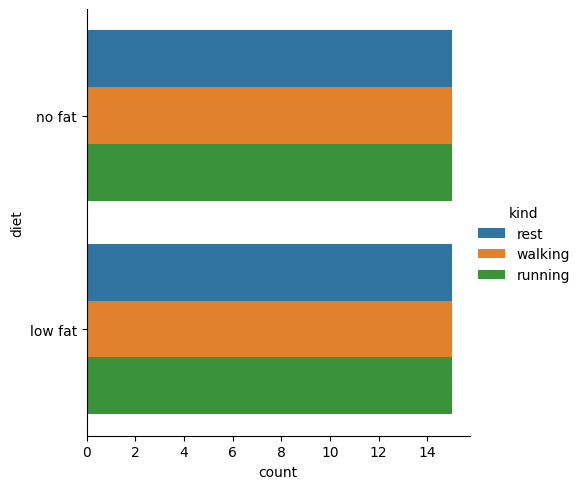

In [3]:
sns.catplot(
    df,
    y='diet',
    kind='count',
    hue='kind',
)

In [4]:
df['time'].unique()

['1 min', '15 min', '30 min']
Categories (3, object): ['1 min', '15 min', '30 min']

In [5]:
df['id'].nunique()

30

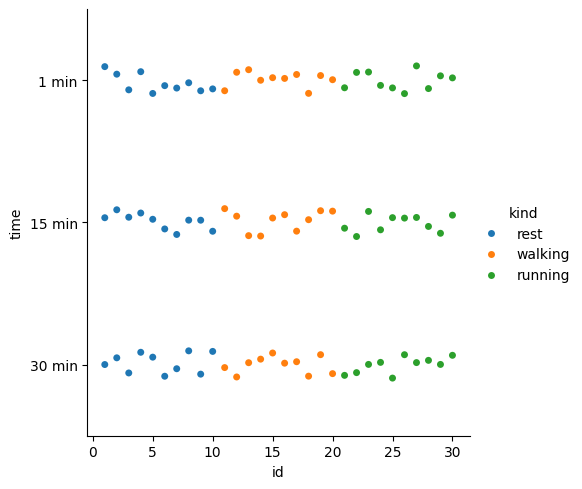

In [6]:
sns.catplot(
    df,
    x='id',
    y='time',
    hue='kind'
)

Parece que el dataset consta de datos de 30 pacientes, seguidos en tres tiempos, al minuto 1, 15 y 30. Cada sujeto de estudio recibía un tipo de dieta y se sometió a un tipo distinto de ejercicio (o reposo).

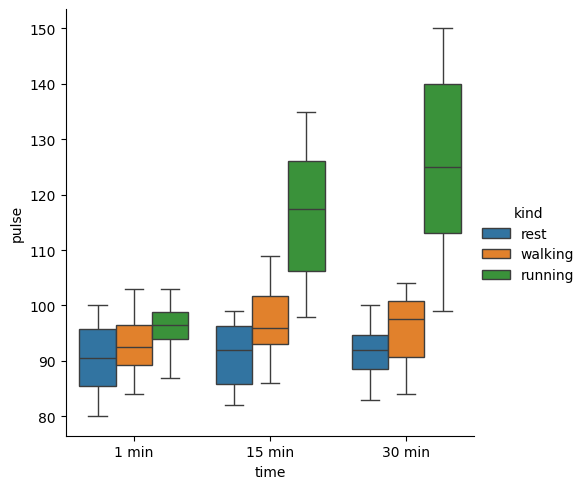

In [7]:
sns.catplot(
    df,
    y='pulse',
    x='time',
    hue='kind',
    kind='box'
)

Podemos ver que la frecuencia cardiaca parece ser dependiente del tipo de ejercicio y del tiempo.

Podemos asumir la ecuación lineal:

$$
pulso ~ tiempo * tipo + dieta
$$

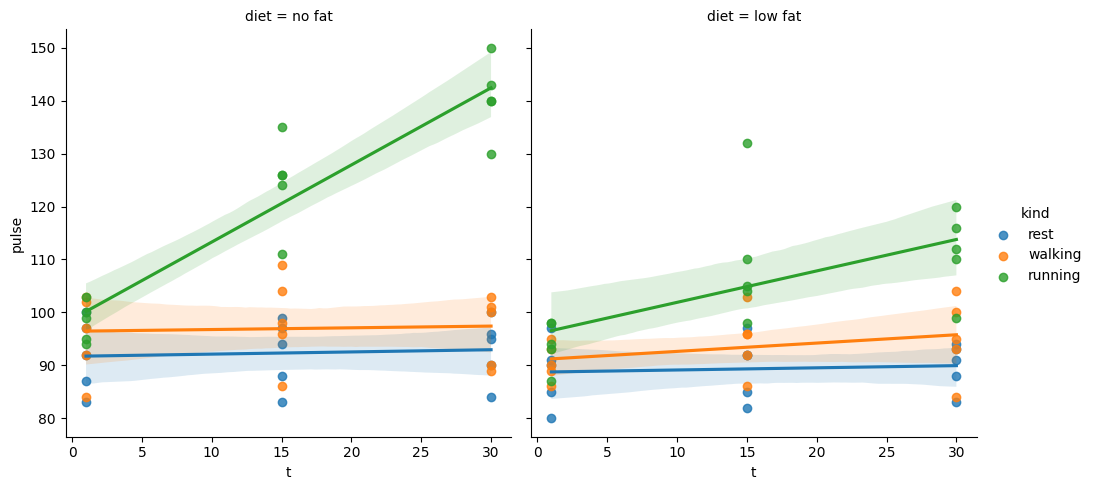

In [8]:
# no podemos meter en el modelo lineal el tiempo como tal, porque actualmente es categórica
# crearemos una nueva columna con los valores numéricos
df['t'] = df['time'].map(
    {'1 min': 1, '15 min': 15, '30 min': 30}
).astype(int)

sns.lmplot(
    df,
    y='pulse',
    x='t',
    hue='kind',
    col='diet',
)

Visualicemos el modelo mixto que implementaremos.

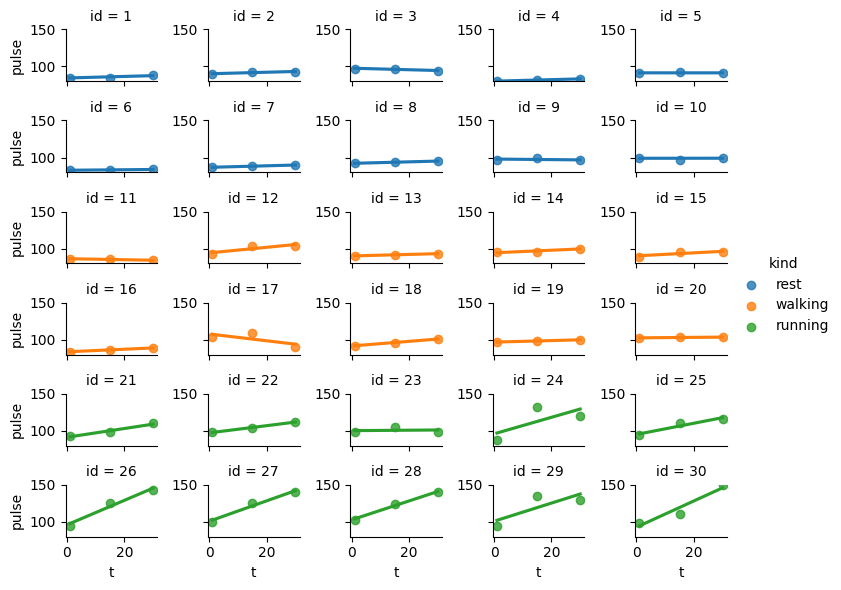

In [9]:
g = sns.lmplot(
    df,
    x='t',
    y='pulse',
    col='id',   # define la variable que se pone en las columnas
    col_wrap=5, # cada 5 pasa a la siguiente fila
    ci=None,    # quitamos el ci que no tiene sentido aquí
    hue='kind', # separamos por tipo para identificarlos grupos
    height=1,   # hacemos que el gráficos sea más compacto y amigable
    aspect=1.5, # hacemos que el gráfico sea más ancho que largo
)
g.set(ylim=[df['pulse'].min(), df['pulse'].max()])

Podemos ver que en el grupo de carrera, todos los participantes, excepto el 23 incrementaron su frecuencia cardiaca, mientras que en los otros dos grupos hay más variabilidad. Efectivamente hay interacción entre el efecto del tiempo y el tipo de ejercicio y cada paciente responde de forma distinta.

## Modelo

La especificación de fórmulas en `bambi` es distinta a la de `statsmodels`, y se asemeja más a la sintaxis de R. 

En `statsmodels`, los efectos aleatorios se indican a través del argumento `groups`, por ejemplo `groups=id`. En cambio, en `bambi`, los efectos aleatorios se incorporan directamente en la fórmula, utilizando la notación `(1 | id)`, lo cual indica explícitamente que cada sujeto (`id`) tendrá un intercepto aleatorio en el modelo.

Si se desea incluir pendientes aleatorias además del intercepto, se puede utilizar la notación `(variable | id)`. Por ejemplo, si se plantea que el efecto del tipo de ejercicio (`kind`) varía entre sujetos, se especifica `(kind | id)`. Para un modelo más complejo que permita que tanto el efecto del tipo de ejercicio como el del tiempo varíen por sujeto, se puede usar `(kind + time | id)`.

Este tipo de especificación permite modelar adecuadamente la estructura jerárquica de los datos cuando se tienen observaciones repetidas por individuo.


In [10]:
model = bmb.Model(
    'pulse ~ t * kind + diet + (1|id)',
    data=df,
    dropna=True,
)
model

       Formula: pulse ~ t * kind + diet + (1|id)
        Family: gaussian
          Link: mu = identity
  Observations: 90
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 99.7, sigma: 84.271)
            t ~ Normal(mu: 0.0, sigma: 3.1195)
            kind ~ Normal(mu: [0. 0.], sigma: [78.3599 78.3599])
            t:kind ~ Normal(mu: [0. 0.], sigma: [3.7128 3.7128])
            diet ~ Normal(mu: 0.0, sigma: 73.8785)
        
        Group-level effects
            1|id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 84.271))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 14.7757)

In [11]:
result = model.fit(random_seed=42) # ajustamos el modelo
# observa que en este caso especificamos una semilla para que los resultados
# sean replicables.

Initializing NUTS using jitter+adapt_diag...
C:\Users\User\Documents\coding\curso_python\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, t, kind, t:kind, diet, 1|id_sigma, 1|id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


## Diagnóstico de convergencia

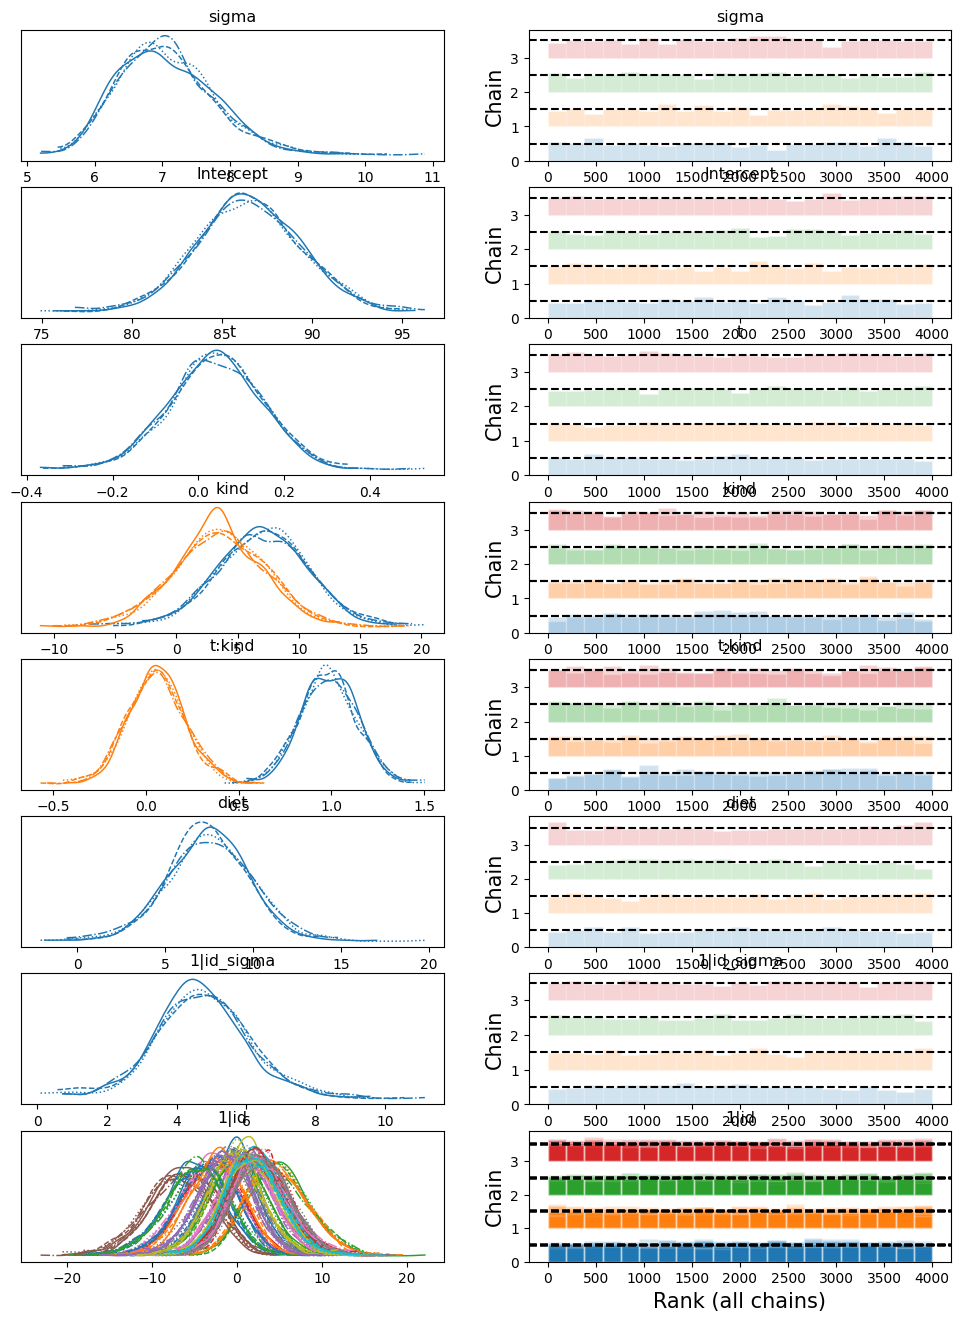

In [12]:
az.plot_trace(
    result, 
    kind='rank_bars',
);

Parece que las cadenas convergieron exitósamente, ahora veamos los resultados.

## Análisis de coeficientes
Necesitamos especificar ahora las variables de interés, puesto que summary y las demás funciones nos darían la información de cada sujeto de forma individual.


In [13]:
variables = [
    'Intercept', # media al tiempo 1
    'sigma', # variabilidad general
    '1|id_sigma', # variabilidad entre sujetos
    't', # efecto del tiempo
    'kind', # efecto del ejercicio
    'diet', # efecto de la dieta
    't:kind', # interacción entre el tiempo y el ejercicio
]
az.summary(result, var_names=variables) # nota que los resultados salen ordenados como los especificamos


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,86.486,2.908,81.255,92.113,0.056,0.048,2676.0,2635.0,1.0
sigma,7.060,0.708,5.841,8.387,0.017,0.012,1796.0,2265.0,1.0
1|id_sigma,4.722,1.376,2.110,7.474,0.046,0.031,915.0,1075.0,1.0
t,0.040,0.108,-0.149,0.249,0.002,0.002,3078.0,2839.0,1.0
kind[running],7.088,3.760,0.456,14.549,0.072,0.064,2737.0,2780.0,1.0
kind[walking],3.509,3.744,-3.621,10.449,0.071,0.064,2762.0,2530.0,1.0
diet[no fat],7.459,2.396,3.030,11.993,0.046,0.054,2808.0,1675.0,1.0
t:kind[running],0.983,0.153,0.705,1.274,0.003,0.002,3408.0,3059.0,1.0
t:kind[walking],0.056,0.155,-0.219,0.365,0.003,0.002,3495.0,3114.0,1.0


Analicemos los coeficientes de los factores con base en su distribución posterior y el margen de credibilidad de su diferencia de cero.

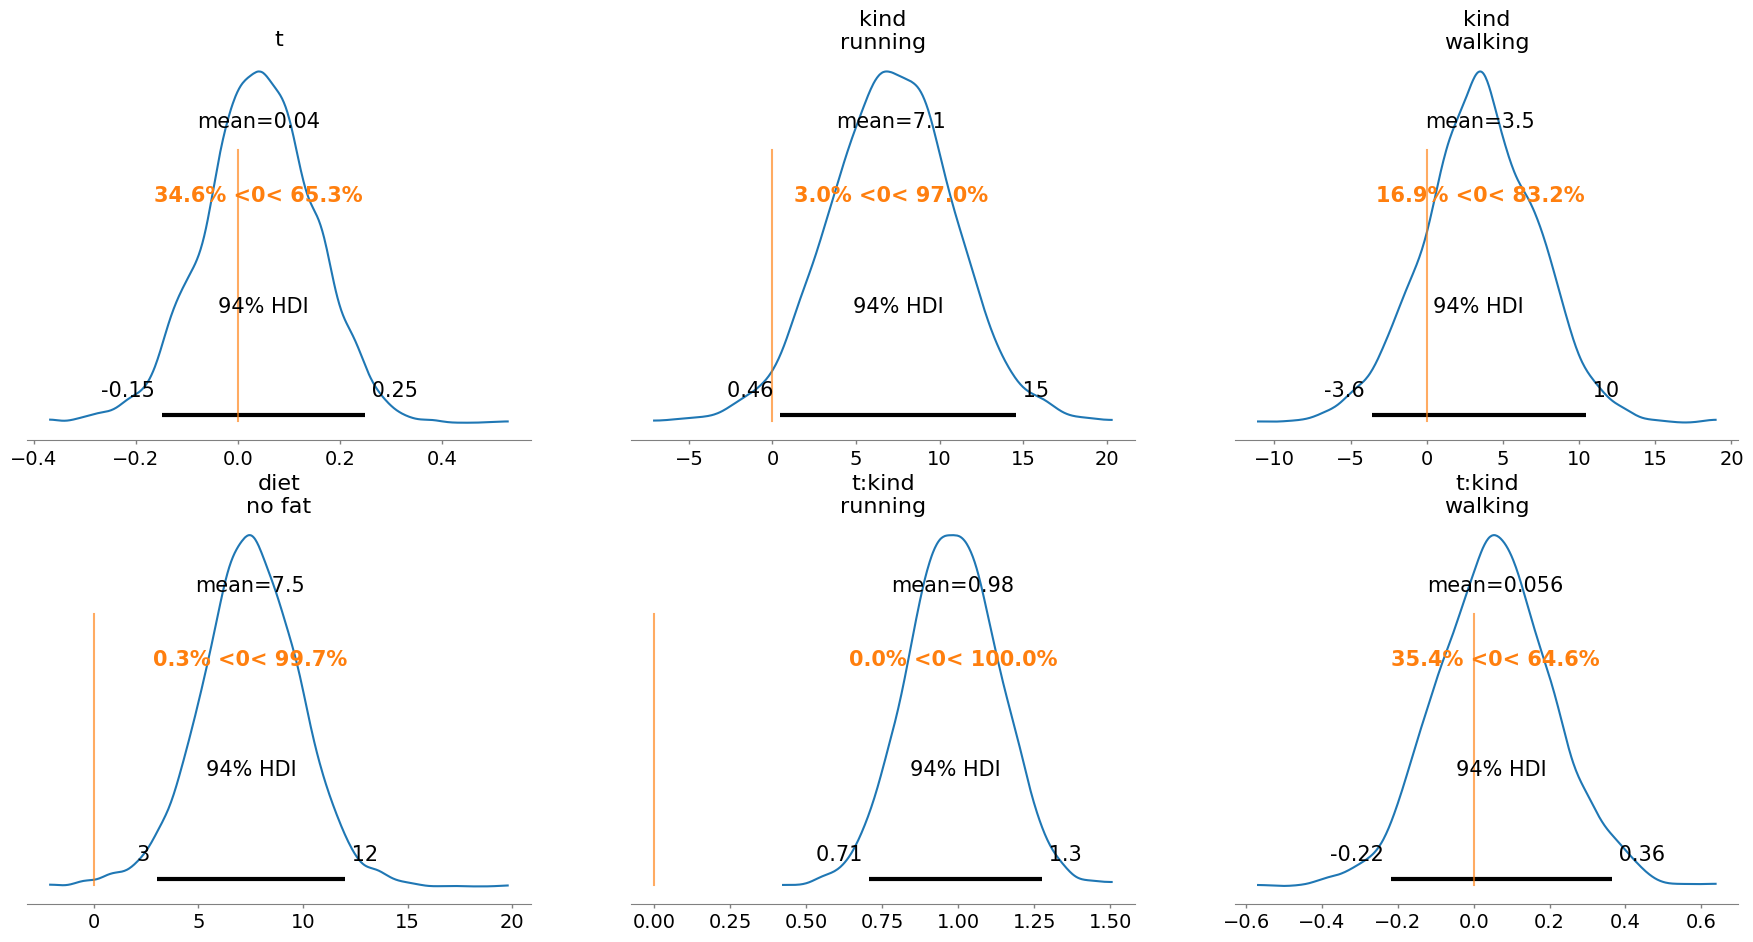

In [14]:
az.plot_posterior(
    result, 
    var_names=variables[3:], # solo desde t
    ref_val=0,
);

## Interpretación de resultados

Conceptualmente, tiene sentido que el tiempo por sí solo no tenga un efecto relevante sobre la frecuencia cardiaca. En condiciones de reposo, es esperable que la frecuencia se mantenga relativamente estable a lo largo del tiempo. Esto se refleja en el coeficiente de `t`, cuyo valor medio es cercano a cero (0.040 lpm/min) y cuya distribución posterior es amplia, con una probabilidad moderada de ser positiva, pero sin excluir valores negativos (HDI 94% = [-0.15, 0.25]). En otras palabras, **el efecto del tiempo solo se manifiesta cuando se combina con otros factores**, particularmente el tipo de ejercicio.

En contraste, el tipo de ejercicio sí tiene un efecto claro:

- **Correr** eleva la frecuencia cardiaca en **7.1 lpm** en promedio respecto al reposo, con una probabilidad alta de que este efecto sea positivo (HDI 94% = [0.46, 14.55]).
- **Caminar** también tiende a elevarla (**3.5 lpm**), pero el intervalo de credibilidad es más amplio (HDI 94% = [-3.62, 10.45]), por lo que **no se puede afirmar con certeza que el efecto sea distinto de cero**.

En cuanto a la dieta, se observa que quienes siguen una dieta **sin grasa** tienen una frecuencia cardiaca **7.5 lpm más alta** que quienes siguen una dieta baja en grasa, con una probabilidad muy alta de que esta diferencia sea positiva (HDI 94% = [3.03, 11.99]). Este hallazgo podría tener implicaciones metabólicas o cardiovasculares, y amerita mayor exploración.

### Interacciones

El aspecto más informativo del modelo está en las interacciones:

- Para quienes **corren**, la frecuencia cardiaca **aumenta en promedio 0.98 lpm por minuto adicional de ejercicio**, con un HDI estrecho (94% = [0.71, 1.27]) y una probabilidad cercana al 100% de que el efecto sea positivo. Este es un resultado **robusto y fisiológicamente esperado**.
- En cambio, para quienes **caminan**, el incremento es mínimo (**0.06 lpm/min**), con un intervalo de credibilidad que incluye claramente cero (HDI 94% = [-0.22, 0.37]), por lo que **no hay evidencia concluyente de que la frecuencia aumente con el tiempo al caminar**.

### Conclusión

El modelo revela que:

- El **tipo de ejercicio y su duración** son los principales determinantes del cambio en frecuencia cardiaca.
- El **reposo**, como categoría de referencia, permite identificar con claridad los efectos relativos de caminar y correr.
- La **dieta** también parece tener un efecto basal importante sobre la frecuencia cardiaca.
- El tiempo, considerado de forma aislada, no debe interpretarse fuera de su interacción con el ejercicio.

Este enfoque bayesiano no solo permite estimar los efectos esperados, sino también **cuantificar directamente la incertidumbre**, proporcionando una visión más completa y realista del fenómeno observado.
